# Multiple Linear Regression

This notebook explains linear regression models for the purpose of prediction. It discusses the differences between fitting and using regression models for the purpose of inference (as in classical statistics) and for prediction. A predictive goal calls for evaluating model performance on a validation set, and for using predictive metrics. It then raises the challenges of using many predictors and describes variable selection algorithms that are often implemented in linear regression procedures.

## Imports

Imports required for this notebook

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from dmutils import regression_summary
from dmutils import adjusted_r2_score, AIC_score
from dmutils import exhaustive_search, backward_elimination
from dmutils import forward_selection, stepwise_selection

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

## Introduction

The most popular model for making predictions is the *multiple linear regression model* encountered in most introductory statistics courses and textbooks. This model is used to fit a relationship between a numerical *outcome variable Y* (also called the *response*, *target*, or *dependent variable*) and a set of *predictors* $X_1$, $X_2$, ..., $X_p$ (also referred to as *independent variables*, *input variables*, *regressors*, or *covariates*). The assumption is that the following function approximates the relationship between the predictors and outcome variable:


<p>
    <center>
        $Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon$
    </center>
</p>

where $\beta_0$, ..., $\beta_p$ are *coefficients* and $\epsilon$ is the *noise* or *unexplained* part. Data are then used to estimate the coefficients and to quantify the noise. In predictive modeling, the data are also used to evaluate model performance.

Regression modeling means not only estimating the coefficients but also choosing which predictors to include and in what form. For example, a numerical predictor can be included as is, or in logarithmic form $[\log (X)]$, or in a binned form (e.g., age group). Choosing the right form depends on domain knowledge, data availability, and needed predictive power.

Multiple linear regression is applicable to numerous predictive modeling situations. Examples are predicting customer activity on credit cards from their demographics and historical activity patterns, predicting expenditures on vacation travel based on historical frequent flyer data, predicting staffing requirements at help desks based on historical data and product and sales information, predicting sales from cross-selling of products from historical information, and predicting the impact of discounts on sales in retail outlets.

## Exploratory vs. Predictive modeling

Before introducing the use of linear regression for prediction, one must clarify an important distinction that often escapes those with earlier familiarity with linear regression from courses in statistics. In particular, the two popular but different objectives behind fitting a regression model are:

1. Explaining or quantifying the average effect of inputs on an outcome (explanatory or descriptive task, respectively)

2. Predicting the outcome value for new records, given their input values (predictive task)

The classical statistical approach is focused on the first objective. In that scenario, the data are treated as a random sample from a larger population of interest. The regression model estimated from this sample is an attempt to capture the *average* relationship in the larger population. This model is then used in decision-making to generate statements such as "a unit increase in service speed ($X_1$) is associated with an average increase of 5 points in customer satisfaction ($Y$), all other factors ($X_2$, $X_3$, ..., $X_p$) being equal.". If $X_1$ is known to cause $Y$, then such a statement indicates actionable policy changes - this is called explanatory modeling. When the causal structure is unknown, then this model quantifies the degree of* association* between the inputs and outcome variable, and the approach is called descriptive modeling.

In predictive analytics, however, the focus is typically on the second goal: predicting new individual records. Here we are not interested in the coefficients themselves, nor in the "average record", but rather in the predictions that this model can generate for new records. In this scenario, the model is used for micro-decision-making at the record level. As a practical example, it could be used to predict customer satisfaction for each new customer of interest.

Both explanatory and predictive modeling involve using a dataset to fit a model (i.e., to estimate coefficients), checking model validity, assessing its performance, and comparing to other models. However, the modeling steps and performance assessment differ in the two cases, usually leading to different final models. Therefore, the choice of model is closely tied to whether the goal is explanatory or predictive.

In explanatory and descriptive modeling, where the focus is on modeling the average record, the attempt is to fit the best model to the data to learn about the underlying relationship in the population. In contrast, in predictive modeling (data mining), the goal is to find a regression model that best predicts new individual records. A regression model that fits the existing data too well is not likely to perform well with new data. Hence, we look for a model that has the highest predictive power by evaluating it on a holdout set and using predictive metrics.

Let us summarize the main differences in using a linear regression in the two scenarios:

1. A good explanatory model is one that fits the data closely, whereas a good predictive model is one that predicts new records accurately. Choices of input variables and their form can therefore differ.

2. In explanatory models, the entire dataset is used for estimating the best-fit model, to maximize the amount of information that we have about the hypothesized relationship in the population. When the goal is to predict outcomes of new individual records, the data are typically split into a training set and a validation set. The training set is used to estimate the model, and the validation or *holdout set* is used to assess this model's predictive performance on new, unobserved data.

3. Performance measures for explanatory models measure how close the data fit the model (how well the model approximates the data) and how strong the average relationship is, whereas in predictive models performance is measured by predictive accuracy (how well the model predicts new individual records).

4. In explanatory models the focus is on the coefficients ($\beta$), whereas in predictive models the focus is on the predictions ($\hat{y}$).

For these reasons, it is extremely important to know the goal of the analysis before beginning the modeling process. A good predictive model can have a looser fit to the data on which it is based, and a good explanatory model can have low prediction accuracy. Therefore, the remainder of this notebook focuses on predictive models because these are more popular in data mining and because most statistics textbooks focus on explanatory modeling.

## Estimating the Regression Equation and Prediction

Once determined the predictors to include and their form, we estimate the coefficients of the regression formula from the data using a method called *ordinary least squares* (OLS). This method finds values $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, ..., $\hat{\beta}_p$ that minimize the sum of squared deviations between the actual outcome values ($Y$) and their predicted values based on that model ($\hat{Y}$).

To predict the value of the outcome variable for a record with predictor values $x_1$, $x_2$, ..., $x_p$, we use the equation:

<p>
    <center>
        $\hat{Y} = \hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 + ... + \hat{\beta}_p x_p$
    </center>
</p>

Predictions based on this equation are the best predictions possible in the sense that they will be unbiased (equal to the true values on average) and will have the smallest mean squared error compared to any unbiased estimates *if* we make the following assumptions:

1. The noise $\epsilon$ (or equivalently, $Y$) follows a normal distribution.

2. The choice of predictors and their form is correct (*linearity*).

3. The records are independent of each other.

4. The variability in the outcome values for a given set of predictors is the same regardless of the values of the predictors (*homoskedasticity*).

An important and interesting fact for the predictive goal is that *even if we drop the first assumption and allow the noise to follow an arbitrary distribution, these estimates are very good for prediction*, in the sense that among all linear models, as defined by equation above, the model using the least squares estimates, $\hat{\beta}_0$, $\hat{\beta}_1$, $\hat{\beta}_2$, ..., $\hat{\beta}_p$, will have the smallest mean squared errors. The assumption of a normal distribution is required in explanatory modeling, where it is used for constructing confidence intervals and statistical tests for the model parameters.

Even if the other assumptions are violated, it is still possible that the resulting predictions are sufficiently accurate and precise for the purpose they are intended for. The key is to evaluate predictive performance of the model, which is the main priority. Satisfying assumptions is of secondary interest and residual analysis can give clues to potential improved models to examine.

### Example: Predicting the Price of Used Toyota Corolla Cars

A large Toyota car dealership offers purchasers of new Toyota cars the option to buy their used car as part of a trade-in. In particular, a new promotion promises to pay high prices for used Toyota Corolla cars for purchasers of a new car. The dealer then sells the used cars for a small profit. To ensure a reasonable profit, the dealer needs to be able to predict the price that the dealership will get for the used cars. For that reason, data were collected on all previous sales of used Toyota Corollas at the dealership. The data include the sales price and other information on the car, such as its age, mileage, fuel type, and engine size. A description of each of these variables is given below:


    Price: Offer price in Euros
    Age: Age in months as of August 2004
    Kilometers: Accumulated kilometers on odometer
    Fuel type: Fuel type (Petrol, Diesel, CNG)
    HP: Horsepower
    Metallic: Metallic color? (Yes = 1, No = 0)
    Automatic: Automatic (Yes = 1, No = 0)
    CC: Cylinder volume in cubic centimeters
    Doors: Number of doors
    QuartTax: Quarterly road tax in Euros
    Weight: Weight in kilograms

A sample of this dataset is shown below. The total number of records in the dataset is 1000 cars (we use the first 1000 cars from the dataset `ToyotoCorolla.csv`).After partitioning the data into training (60%) and validation
(40%) sets, we fit a multiple linear regression model between price (the outcome variable) and the other variables (as predictors) using only the training set.

In [2]:
# reduce data frame to the top 1000 rows and select columns for regression analysis
car_df = pd.read_csv("../datasets/ToyotaCorolla.csv")
car_df = car_df.iloc[0:1000]

car_df.head(5)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,...,1,1,0,0,0,1,0,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
2,3,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,...,0,1,0,0,0,1,0,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,...,0,1,0,0,0,1,0,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,...,1,1,0,1,0,1,0,0,0,0


Below are the coefficients of the Multiple Linear Regression model:

In [3]:
predictors = ["Age_08_04", "KM", "Fuel_Type", "HP", "Met_Color", "Automatic", "CC",
              "Doors", "Quarterly_Tax", "Weight"]
outcome = "Price"

# partition data
X = pd.get_dummies(car_df[predictors], drop_first=True)
y = car_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.4,
                                                      random_state=1)
car_lmr = LinearRegression()
car_lmr.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lmr.coef_}))
# print performance measures (training data)
regression_summary(train_y, car_lmr.predict(train_X))

           Predictor  coefficient
0          Age_08_04  -140.748761
1                 KM    -0.017840
2                 HP    36.103419
3          Met_Color    84.281830
4          Automatic   416.781954
5                 CC     0.017737
6              Doors   -50.657863
7      Quarterly_Tax    13.625325
8             Weight    13.038711
9   Fuel_Type_Diesel  1066.464681
10  Fuel_Type_Petrol  2310.249543

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1400.5823
            Mean Absolute Error (MAE) : 1046.9072
          Mean Percentage Error (MPE) : -1.0223
Mean Absolute Percentage Error (MAPE) : 9.2994


Notice that the Fuel Type predictor has three categories (Petrol, Diesel, and CNG). We therefore have two dummy variables in the model: Fuel_Type_Petrol (0/1) and Fuel_Type_Diesel (0/1); the third, for CNG (0/1), is redundant given the information on the first two dummies. Including the redundant dummy would cause the regression to fail, since the redundant dummy will be a perfect linear combination of the other two.

The regression coefficients are then used to predict prices of individual used Toyota Corolla cars based on their age, mileage, and so on. Below is a sample of predicted prices for 20 cars in the validation set, using the estimated model. It gives the predictions and their errors (relative to the actual prices) for these 20 cars. Below the predictions, we have overall measures of predictive accuracy. Note that the mean
error (ME) is \\$104 and RMSE = \\$1,313.

In [4]:
# Use predict() to make predictions on a new set
car_lmr_pred = car_lmr.predict(valid_X)
result = pd.DataFrame({"Predicted": car_lmr_pred,
                       "Actual": valid_y,
                       "Residual": valid_y - car_lmr_pred})
print(result.head(20))
# print performance measures (validation data)
regression_summary(valid_y, car_lmr_pred)

        Predicted  Actual     Residual
507  10607.333940   11500   892.666060
818   9272.705792    8950  -322.705792
452  10617.947808   11450   832.052192
368  13600.396275   11450 -2150.396275
242  12396.694660   11950  -446.694660
929   9496.498212    9995   498.501788
262  12480.063217   13500  1019.936783
810   8834.146068    7950  -884.146068
318  12183.361282    9900 -2283.361282
49   19206.965683   21950  2743.034317
446  10987.498309   11950   962.501691
142  18501.527375   19950  1448.472625
968   9914.690947    9950    35.309053
345  13827.299932   14950  1122.700068
971   7966.732543   10495  2528.267457
133  17185.242041   15950 -1235.242041
104  19952.658062   19450  -502.658062
6    16570.609280   16900   329.390720
600  13739.409113   11250 -2489.409113
496  11267.513740   11750   482.486260

Regression statistics

                      Mean Error (ME) : 103.6803
       Root Mean Squared Error (RMSE) : 1312.8523
            Mean Absolute Error (MAE) : 1017.5972
        

A histogram of the residuals shows that most of the errors are between ± \\$2000. This error magnitude might be small relative to the car price, but should be taken into account when considering the profit. Another observation of interest is the large positive residuals (under-predictions), which may or may not be a concern, depending on the application. Measures such as the mean error, and error percentiles are used to assess the predictive performance of a model and to compare models.

Percentage of datapoints with a residual in [-1406, 1406]:  0.7425


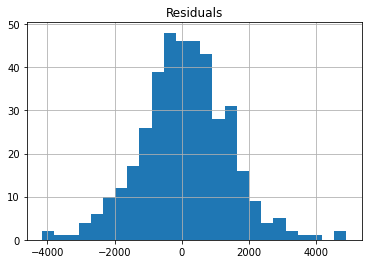

In [5]:
all_residuals = valid_y - car_lmr_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75%
print("Percentage of datapoints with a residual in [-1406, 1406]: ",
      len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

pd.DataFrame({"Residuals": all_residuals}).hist(bins=25)
plt.show()

## Variable Selection in Linear Regression

### Reducing the Number of Predictors

A frequent problem in data mining is that of using a regression equation to predict the value of a dependent variable when we have many variables available to choose as predictors in our model. Given the high speed of modern algorithms for multiple linear regression calculations, it is tempting in such a situation to take a kitchen-sink approach: Why bother to select a subset? Just use all the variables in the model.

Another consideration favoring the inclusions of numerous variables is the hope that a previously hidden relationship will emerge. For example, a company found that customers who had purchased anti-scuff protectors for chair and table legs had lower credit risks. However, there are several reasons for exercising caution before throwing all possible variables into a model.

   - It may be expensive or not feasible to collect a full complement of predictors for future predictions.
   - We may be able to measure fewer predictors more accurately (e.g., in surveys).
   - The more predictors, the higher the chance of missing values in the data. If we delete or impute records with missing values, multiple predictors will lead to a higher rate of record deletion or imputation.
   - *Parsimony* is an important property of good models. We obtain more insight into the influence of predictors in models with few parameters.
   - Estimates of regression coefficients are likely to be unstable, due to *multicollinearity* in models with many variables. (Multicollinearity is the presence of two or more predictors sharing the same linear relationship with the outcome variable.) Regression coefficients are more stable for parsimonious models. One very rough rule of thumb is to have a number of records *n* larger than 5(*p* + 2), where *p* is the number of predictors.
   - It can be shown that using predictors that are uncorrelated with the outcome variable increases the variance of predictions.
   - It can be shown that dropping predictors that are actually correlated with the outcome variable can increase the average error (bias) of predictions.

The last two points mean that there is a trade-off between too few and too many predictors. In general, accepting some bias can reduce the variance in predictions. This *bias-variance* trade-off is particularly important for large numbers of predictors, because in that case, it is very likely that there are variables in the model that have small coefficients relative to the standard deviation of the noise and also exhibit at least moderate correlation with other variables. Dropping such variables will improve the predictions, as it reduces the prediction variance. This type of bias-variance trade-off is a basic aspect of most data mining procedures for prediction and classification. In light of this, methods for reducing the number of predictors p to a smaller set are often used.

### How to Reduce the Number of Predictors

The first step in trying to reduce the number of predictors should always be to use domain knowledge. It is important to understand what the various predictors are measuring and why they are relevant for predicting the outcome variable. With this knowledge, the set of predictors should be reduced to a sensible set that reflects the
problem at hand. Some practical reasons for predictor elimination are the expense of collecting this information in the future; inaccuracy; high correlation with another predictor; many missing values; or simply irrelevance. Also helpful in examining potential predictors are summary statistics and graphs, such as frequency and correlation tables, predictor-specific summary statistics and plots, and missing value counts.

The next step makes use of computational power and statistical performance metrics. In general, there are two types of methods for reducing the number of predictors in a model. The first is an *exhaustive search* for the "best" subset of predictors by fitting regression models with all the possible combinations of predictors. The exhaustive search approach is not practical in many applications due to the large number of possible models. The second approach is to search through a partial set of models. We describe these two approaches next.

#### Exhaustive Search

The idea here is to evaluate all subsets of predictors. Since the number of subsets for even moderate values of *p* is very large, after the algorithm creates the subsets and runs all the models, we need some way to examine the most promising subsets and to select from them. The challenge is to select a model that is not too simplistic in terms of excluding important parameters (the model is *under-fit*), nor overly complex thereby modeling random noise (the model is *over-fit*). Several criteria for evaluating and comparing models are based on metrics computed from the training data:

<p>
    <center>
        $R^{2}_{adj} = 1 -\frac{n - 1}{n - p - 1} (1 - R^2)$,
    </center>
</p>

where $R^2$ is the proportion of explained variability in the model (in a model with a single predictor, this is the squared correlation). Like $R^2$, higher values of $R^{2}_{adj}$ indicate better fit. Unlike $R^2$, which does not account for the number of predictors used, $R^{2}_{adj}$ uses a penalty on the number of predictors. This avoids the artificial increase in $R^2$ that can result from simply increasing the number of predictors but not the amount of information. It can be shown that using $R^{2}_{adj}$ to choose a subset is equivalent to choosing the subset that minimizes the training RMSE.

A second popular set of criteria for balancing under-fitting and over-fitting are the *Akaike Information Criterion (AIC)* and *Schwartz’s Bayesian Information Criterion (BIC)*. AIC and BIC measure the goodness of fit of a model, but also include a penalty that is a function of the number of parameters in the model. As such, they can be used to compare various models for the same data set. *AIC* and *BIC* are estimates of prediction error based in information theory. For linear regression, AIC and BIC can be computed from the formulas:

<p>
    <center>
        $$AIC = n \ln(\frac{SSE}{n}) + n (1 + \ln(2\pi)) + 2 (p + 1)$$,
    </center>
</p>

<p>
    <center>
        $BIC = n \ln(\frac{SSE}{n}) + n (1 + \ln(2\pi)) + \ln(n)(p + 1)$,
    </center>
</p>

where SSE is the model's sum of squared errors. In general, models with smaller AIC and BIC values are considered better.

Finally, a useful point to note is that for a fixed size of subset $R^{2}$, $R^{2}_{adj}$, AIC, and BIC
all select the same subset. In fact, there is no difference between them in the order of merit they ascribe to subsets of a fixed size. This is good to know if comparing models with the same number of predictors, but often we want to compare models with different numbers of predictors.

Following are the results of of applying an exhaustive search on the Toyota Corolla price data (with the 11 predictors). Because Python does not have an exhaustive search routine, we created a loop that iterates through all predictor combinations and within models with the same number of predictors, selects the models with the highest $R^{2}_{adj}$ (which is equivalent to choosing one of the other measures mentioned above). The code reports the best model with a single predictor, two predictors, and so on. It can be seen that the $R^{2}_{adj}$ increases until eight predictors are used and then slowly decreases. The AIC also indicates that a model with  eight predictors is good. The dominant predictor in all models is the age of the car, with horsepower, weight and mileage playing important roles as well.

In [6]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

all_variables = train_X.columns
results = exhaustive_search(all_variables, train_model, score_model)

data = []
for result in results:
    model = result["model"]
    variables = list(result["variables"])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)

    d = {"n": result["n"], "r2adj": -result["score"], "AIC": AIC}
    d.update({var: var in result["variables"] for var in sorted(all_variables)})
    data.append(d)

pd.DataFrame(data, columns=("n", "r2adj", "AIC") + tuple(sorted(all_variables)))

,n,r2adj,AIC,Age_08_04,Automatic,CC,Doors,Fuel_Type_Diesel,Fuel_Type_Petrol,HP,KM,Met_Color,Quarterly_Tax,Weight
0,1,0.767901,10689.712094,True,False,False,False,False,False,False,False,False,False,False
1,2,0.801160,10597.910645,True,False,False,False,False,False,True,False,False,False,False
2,3,0.829659,10506.084235,True,False,False,False,False,False,True,False,False,False,True
3,4,0.846357,10445.174820,True,False,False,False,False,False,True,True,False,False,True
4,5,0.849044,10435.578836,True,False,False,False,False,False,True,True,False,True,True
5,6,0.853172,10419.932278,True,False,False,False,False,True,True,True,False,True,True
6,7,0.853860,10418.104025,True,False,False,False,True,True,True,True,False,True,True
7,8,0.854297,10417.290103,True,True,False,False,True,True,True,True,False,True,True
8,9,0.854172,10418.789079,True,True,False,True,True,True,True,True,False,True,True
9,10,0.854036,10420.330800,True,True,False,True,True,True,True,True,True,True,True


#### Popular Subset Selection Algorithms

The second method of finding the best subset of predictors relies on a partial, iterative search through the space of all possible regression models. The end product is one best subset of predictors (although there do exist variations of these methods that identify several close-to-best choices for different sizes of predictor subsets). This approach is computationally cheaper, but it has the potential of missing "good" combinations of predictors. None of the methods guarantee that they yield the best subset for any criterion, such as $R^{2}_{adj}$. They are reasonable methods for situations with a large number of predictors, but for a moderate number of predictors, the exhaustive search is preferable.

Three popular iterative search algorithms are *forward selection*, *backward elimination*, and *stepwise regression*. In *forward selection*, we start with no predictors and then add predictors one by one. Each predictor added is the one (among all predictors) that has the largest contribution to $R^{2}$ on top of the predictors that are already in it. The algorithm stops when the contribution of additional predictors is not
statistically significant. The main disadvantage of this method is that the algorithm will miss pairs or groups of predictors that perform very well together but perform poorly as single predictors. This is similar to interviewing job candidates for a team project one by one, thereby missing groups of candidates who perform superiorly together ("colleagues"), but poorly on their own or with non-colleagues.

In *backward elimination*, we start with all predictors and then at each step, eliminate the least useful predictor (according to statistical significance). The algorithm stops when all the remaining predictors have significant contributions. The weakness of this algorithm is that computing the initial model with all predictors can be time-consuming and unstable. *Stepwise regression* is like forward selection except that at each step, we consider dropping predictors that are not statistically significant, as in backward elimination.

There is currently no support in scikit-learn or statsmodels for stepwise regression. It is however straightforward to implement such an approach in a few lines of code (see `src/dmutils/feature_selection.py` module). The below table shows the result of backward elimination for the Toyota Corolla example. The chosen eight-predictor model is identical to the best eight-predictor model chosen by the exhaustive search.

In [7]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)


all_variables = train_X.columns
best_model, best_variables = backward_elimination(all_variables, train_model, score_model,
                                                  verbose=True)
print(best_model)

regression_summary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=10422.30
Step: score=10420.33, remove=CC
Step: score=10418.79, remove=Met_Color
Step: score=10417.29, remove=Doors
Step: score=10417.29, remove=None
LinearRegression()

Regression statistics

                      Mean Error (ME) : 103.3045
       Root Mean Squared Error (RMSE) : 1314.4844
            Mean Absolute Error (MAE) : 1016.8875
          Mean Percentage Error (MPE) : -0.2700
Mean Absolute Percentage Error (MAPE) : 8.9984


In this example, forward selection as well as stepwise regression also end up with this same eight-predictor model. This need not be the case with other datasets.

In [8]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model,
                                               score_model, verbose=True)
print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, add None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


In [9]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model,
                                                score_model, verbose=True)
print(best_variables)

Variables: Age_08_04, KM, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight, Fuel_Type_Diesel, Fuel_Type_Petrol
Start: score=11565.07, constant
Step: score=10689.71, add Age_08_04
Step: score=10597.91, add HP
Step: score=10506.08, add Weight
Step: score=10445.17, add KM
Step: score=10435.58, add Quarterly_Tax
Step: score=10419.93, add Fuel_Type_Petrol
Step: score=10418.10, add Fuel_Type_Diesel
Step: score=10417.29, add Automatic
Step: score=10417.29, unchanged None
['Age_08_04', 'HP', 'Weight', 'KM', 'Quarterly_Tax', 'Fuel_Type_Petrol', 'Fuel_Type_Diesel', 'Automatic']


Once one or more promising models are selected, we run them to evaluate their validation predictive performance. For example, the above table shows the validation performance of the 8-predictor model, which turns out to be only very slightly better than the 10-predictor model in terms of validation metrics. It is possible there may an even smaller model, performing only slightly worse, that is preferable from a parsimony standpoint.

Finally, additional ways to reduce the dimension of the data are by using principal components and regression trees.

### Regularization (Shrinkage Models)

Selecting a subset of predictors is equivalent to setting some of the model coefficients to zero. This approach creates an interpretable result - we know which predictors were dropped and which are retained. A more flexible alternative, called regularization or shrinkage, "shrinks" the coefficients toward zero. Recall that adjusted $R^2$ incorporates a penalty according to the number of predictors $p$. Shrinkage methods also impose a penalty on the model fit, except that the penalty is not based on the $number$ of predictors but rather on some aggregation of the coefficient values (typically predictors are first standardized to have the same scale).

The reasoning behind constraining the magnitude of the $\hat{\beta}$ coefficients is that highly correlated predictors will tend to exhibit coefficients with high standard errors, since small changes in the training data might radically shift which of the correlated predictors gets emphasized. This instability (high standard errors) leads to poor predictive power. By constraining the combined magnitude of the coefficients, this variance is reduced.

The two most popular shrinkage methods are *ridge regression* and *lasso*. They differ in terms of the penalty used: In ridge regression, the penalty is based on the sum of squared coefficients

<p>
    <center>
        $\sum^{p}_{j = 1}\beta_{j}^{2}$, called L2 penalty
    </center>
</p>

whereas lasso uses the sum of absolute values

<p>
    <center>
        $\sum^{p}_{j = 1}|\beta_{j}|$, called L1 penalty
    </center>
</p>

for $p$ predictors (excluding an intercept). It turns out that the lasso penalty effectively shrinks some of the coefficients to zero, thereby resulting in a subset of predictors.

Whereas in linear regression coefficients are estimated by minimizing the training data sum of squared errors (SSE), in ridge regression and lasso the coefficients are estimated by minimizing the training data SSE, subject to the penalty term being below some threshold $t$. This threshold can be set by the user, or chosen by cross-validation.

In Python, regularized linear regression can be run using methods *Lasso* and *Ridge* in `sklearn.linear_model`.The penalty parameter $\alpha$ determines the threshold (a typical default value is $\alpha$ = 1; note that $\alpha$ = 0 means no penalty and yields ordinary linear regression). The methods `LassoCV`, `RidgeCV`, and `BayesianRidge` offer the added benefit of automatically selecting the penalty parameter. `LassoCV` and `RidgeCV` use cross-validation to determine optimal values for the penalty parameter. A different approach is used in `BayesianRidge` which uses an iterative approach to derive the penalty parameter from the whole training set. Remember to set argument `normalize=True` or otherwise normalize the data before applying regularized regression models.

In [10]:
print("Lasso")
lasso = Lasso(normalize=True, alpha=1)
lasso.fit(train_X, train_y)
regression_summary(valid_y, lasso.predict(valid_X))
print()

print("Lasso CV")
lasso_cv = LassoCV(normalize=True, cv=5)
lasso_cv.fit(train_X, train_y)
regression_summary(valid_y, lasso_cv.predict(valid_X))
print()
print("Lasso-CV chosen regularization: ", lasso_cv.alpha_)
print(["{:.2f}".format(coef) for coef in lasso_cv.coef_])
print()

print("Ridge")
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regression_summary(valid_y, ridge.predict(valid_X))
print()

print("Bayesian Ridge")
bayesian_ridge = BayesianRidge(normalize=True)
bayesian_ridge.fit(train_X, train_y)
regression_summary(valid_y, bayesian_ridge.predict(valid_X))
print()
alpha = bayesian_ridge.lambda_ / bayesian_ridge.alpha_
print("Bayesian ridge chosen regularization: ", alpha)

Lasso

Regression statistics

                      Mean Error (ME) : 120.6311
       Root Mean Squared Error (RMSE) : 1332.2752
            Mean Absolute Error (MAE) : 1021.5286
          Mean Percentage Error (MPE) : -0.2364
Mean Absolute Percentage Error (MAPE) : 9.0115

Lasso CV

Regression statistics

                      Mean Error (ME) : 145.1571
       Root Mean Squared Error (RMSE) : 1397.9428
            Mean Absolute Error (MAE) : 1052.4649
          Mean Percentage Error (MPE) : -0.2966
Mean Absolute Percentage Error (MAPE) : 9.2918

Lasso-CV chosen regularization:  3.5138446691310605
['-140.37', '-0.02', '33.87', '0.00', '69.44', '0.00', '0.00', '2.71', '12.43', '-0.00', '0.00']

Ridge

Regression statistics

                      Mean Error (ME) : 154.3286
       Root Mean Squared Error (RMSE) : 1879.7426
            Mean Absolute Error (MAE) : 1353.2735
          Mean Percentage Error (MPE) : -2.3897
Mean Absolute Percentage Error (MAPE) : 11.1309

Bayesian Ridge

Regre

The above code applies ridge and lasso regression to the Toyota Corolla example. We see that in this case the model performance of the optimized Lasso regression is slightly worse than for normal linear regression. Looking at the coefficients, we see that the lasso approach lead to a model with 6 predictors (Age_08_04, KM, HP, Automatic, Quarterly_Tax, Weight). The regularization parameter derived in `BayesianRidge` regression is very small, which indicates that this dataset does not benefit from regularization. The real strength of these methods becomes more evident when the dataset contains a large number of predictors with high correlation.

### Using Statmodels

An alternative to scikit’s `LinearRegression` is method `sm.ols` in `statmodels`. The latter produces a more extensive output of the statistical properties of the model, suitable for non-predictive tasks such as statistical inference. The following table shows the same model for price vs. car attributes run using `sm.ols`. For regularization, use `statmodels` method `OLS.fit_regularized`. Set argument `L1_wt=0` for ridge regression and `L1_wt=1` for lasso.

In [11]:
# run a linear regression of Price on the remaining 11 predictors in the
# training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = "Price ~ " + " + ".join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
car_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     319.0
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.73e-239
Time:                        23:07:26   Log-Likelihood:                -5198.1
No. Observations:                 600   AIC:                         1.042e+04
Df Residuals:                     588   BIC:                         1.047e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1319.3544   1728.427     -0.763      0.446   -4713.997    2075.288
Age_08_04         -140.7488      5.142    -27.374      0.000    -150.847    -130.650
KM                  -0.0178      0.002     -7.286      0.000      -0.023      -0.013
HP                  36.1034      5.321      6.785      0.000      25.653      46.554
Met_Color           84.2818    127.005      0.664      0.507    -165.158     333.721
Automatic          416.7820    259.794      1.604      0.109     -93.454     927.018
CC                   0.0177      0.099      0.179      0.858      -0.177       0.213
Doors              -50.6579     65.187     -0.777      0.437    -178.686      77.371
Quarterly_Tax       13.6253      2.518      5.411      0.000       8.680      18.571
Weight              13.0387      1.602      8.140      0.000       9.893      16.185
Fuel_Type_Diesel  1066.4647    527.285      2.023      0.044      30.872    2102.057
Fuel_Type_Petrol  2310.2495    521.045      4.434      0.000    1286.914    3333.585
==============================================================================
Omnibus:                       62.422   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.046
Skew:                           0.186   Prob(JB):                     3.27e-80
Kurtosis:                       6.808   Cond. No.                     2.20e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""